# Emotion Image Classifier

## Done By Hamad S. Alassafi


### The notebook will be divided into 8 section

- Business Understanding

- Data Understanding

- Data Preprocessing

- Exploratory Data Analysis

- Model Selection & Developemnt

- Model Evaluation

- Conclusion & Results

- Model Exporting & Notebook Containerization

# Business Understanding

**We have to build an AI model that takes an image of individual face, and classify their emotion as follows:**

1. Angry
2. Disgust
3. Fear
4. Happy
5. Neutral
6. Sad
7. Surprise

In [67]:
import os


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from PIL import Image
import cv2


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


# Data Understanding

**We should have inital understanding about our data in this section:**

1. How can we extract the data (e.g., APIs, Flat files, etc...)
2. Data size, and number of images

### Data Extraction

In [68]:
# Create an empty list to store the image paths and class labels
def loadImages(dir):
    image_paths = []
    class_labels = []

    # Loop through each subdirectory
    for class_dir in os.listdir(dir):
        class_path = os.path.join(dir, class_dir)

        # Loop through each image in the subdirectory
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Append the image path and class label to the lists
            image_paths.append(image_path)
            class_labels.append(class_dir)

    # Create the dataframe
    data = {'image_path': image_paths, 'class': class_labels}
    df = pd.DataFrame(data)
    return df



In [69]:
train_dir = "/kaggle/input/facial-expression-dataset/train/train"
test_dir = "/kaggle/input/facial-expression-dataset/test/test"

In [70]:
df_train = loadImages(train_dir)
df_test = loadImages(test_dir)

### Data size, and number of images

In [71]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Check if it's a file (to avoid issues with symbolic links, etc.)
            if os.path.isfile(file_path):
                total_size += os.path.getsize(file_path)
    return total_size / (1000 ** 2)

# Example usage

train_size = get_folder_size(train_dir)
print(f"Training Set Folder Size: {train_size} mb")

test_size = get_folder_size(test_dir)
print(f"Test Size Set Folder Size: {test_size} mb")


print(f"Dataset total Size: {train_size + test_size} mb")

Training Set Folder Size: 45.185869 mb
Test Size Set Folder Size: 11.32432 mb
Dataset total Size: 56.510189 mb


In [72]:
print("Number of images in training set is: ", df_train.shape[0])
print("Number of images in training set is: ", df_test.shape[0])

print("Total images is: ", df_train.shape[0] + df_test.shape[0])

Number of images in training set is:  28709
Number of images in training set is:  7178
Total images is:  35887


# Data Preprocessing

- Checking for the Data Quality Six Dimensions

- Completeness. 

- Uniqueness.

- Timeliness. ==> Does not applicable, because we do not deal with data that has timing element

- Validity.

- Accuracy.

- Consistency. ==> Does not applicable, because we do not deal with data that have different set of representation in terms of unit (e.g., kg, g, and etc...)


**Since we are dealing with image data, so I have to add extra steps of preprocessing:**

- Reading the as grayscale images
- Image resizing into 48, 48, 1
- Image normaliztion
- Encoding the labels - emotions - 

In [73]:
df_train["flag"] = 1
df_test["flag"] = 0

df = pd.concat([df_train, df_test])

In [74]:
# Completeness

df.isnull().sum()

image_path    0
class         0
flag          0
dtype: int64

**We do not have any completeness issues in the data**

In [75]:
# Uniqueness

df.duplicated(subset = ["image_path"]).sum()

0

**We do not have any duplicated images in the data**

In [76]:
# Validity

def is_valid_image(path):
    try:
        Image.open(path)
        return True
    except:
        return False

# Check if all paths are valid images
all_valid_images = df["image_path"].apply(is_valid_image).all()

if all_valid_images:
    print("All paths are valid image paths.")
else:
    print("Some paths are not valid image paths.")

All paths are valid image paths.


In [77]:
# Accuracy

def display_images(df):
    classes = df['class'].unique()
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    
    for ax, class_name in zip(axes, classes):
        # Select one image per class
        image_path = df[df['class'] == class_name].iloc[0]['image_path']
        
        # Load image using OpenCV
        image = cv2.imread(image_path)
        # Convert BGR to RGB as OpenCV loads images in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')
        
    plt.show()
    



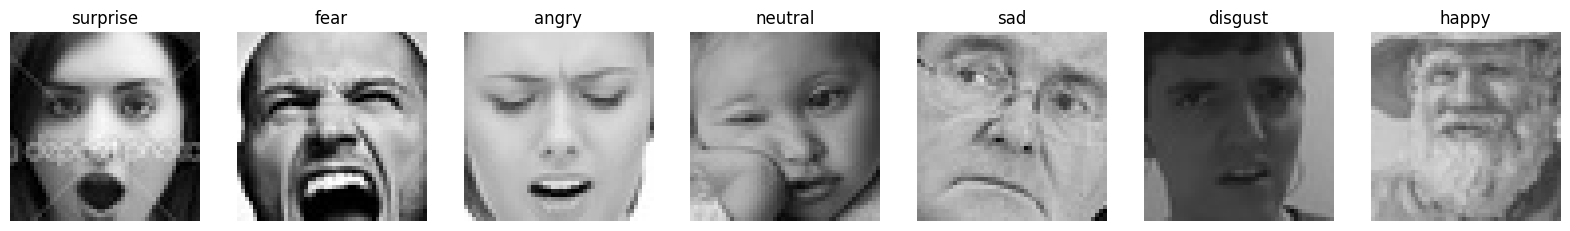

In [78]:
display_images(df_train)

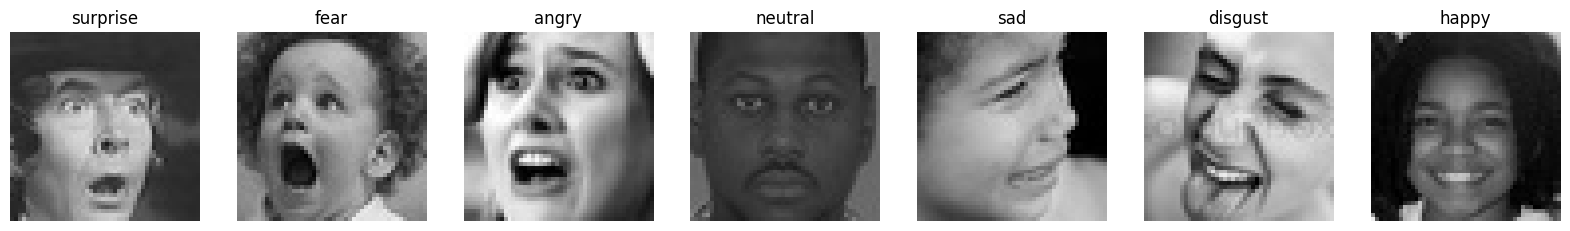

In [79]:
display_images(df_test)

**As we can see from above sample surprise, fear, and angry classes is somehow similar, so we might face difficulty in classifying them**

In [80]:
# Function to load and preprocess images
def load_and_preprocess_images(df, image_size = 48):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_path = row['image_path']
        label = row['class']
        
        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize image
        img = cv2.resize(img, (image_size, image_size))
        
        # Normalize image
        img = img / 255.0
        
        images.append(img)
        labels.append(label)
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Reshape images to add channel dimension
    images = images.reshape(-1, image_size, image_size, 1)
    
    return images, labels

X_train, y_train = load_and_preprocess_images(df_train)
X_test, y_test = load_and_preprocess_images(df_test)

In [81]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

class_to_num = {cls: i for i, cls in enumerate(classes)}

# Convert labels to numerical format
y_train_num = np.array([class_to_num[label] for label in y_train])
y_test_num = np.array([class_to_num[label] for label in y_test])

y_train_one_hot = to_categorical(y_train_num, num_classes=len(classes))
y_test_one_hot = to_categorical(y_test_num, num_classes=len(classes))

In [82]:
y_train[0], y_test_num[0], y_train_one_hot[0]

('surprise', 6, array([0., 0., 0., 0., 0., 0., 1.]))

In [83]:
y_test[1000], y_test_num[1000], y_test_one_hot[1000]

('fear', 2, array([0., 0., 1., 0., 0., 0., 0.]))

# Exploratory Data Analysis

- Understand the data distribution

- Number of images per class

- Do we have balance between the classes overall, and in each set, then we might apply some augmentation based on this info

In [84]:
print("Percentage of training set:", round(len(df[df["flag"] == 1]) / df.shape[0], 3) * 100 , "%", ", and number of images:", len(df[df["flag"] == 1]))
print("Percentage of Test set:", round(1 - (len(df[df["flag"] == 1]) / df.shape[0]), 3) * 100  , "%", ", and number of images:", len(df[df["flag"] == 0]))

Percentage of training set: 80.0 % , and number of images: 28709
Percentage of Test set: 20.0 % , and number of images: 7178


In [85]:
df["class"].value_counts()

class
happy       8989
neutral     6198
sad         6077
fear        5121
angry       4953
surprise    4002
disgust      547
Name: count, dtype: int64

**As we can see from the above table, we have few images of disgust emotion, compared to other emotions, which might makes our model being bais to other classes**

In [86]:
def calculatePercentage(df):
    class_counts = df['class'].value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / len(df) * 100

    # Display the results
    print(class_percentages)

In [87]:
calculatePercentage(df)

class
happy       25.048068
neutral     17.270878
sad         16.933709
fear        14.269791
angry       13.801655
surprise    11.151671
disgust      1.524229
Name: count, dtype: float64


In [88]:
calculatePercentage(df_train)

class
happy       25.131492
neutral     17.294228
sad         16.823992
fear        14.270786
angry       13.915497
surprise    11.045317
disgust      1.518688
Name: count, dtype: float64


In [89]:
calculatePercentage(df_test)

class
happy       24.714405
sad         17.372527
neutral     17.177487
fear        14.265812
angry       13.346336
surprise    11.577041
disgust      1.546392
Name: count, dtype: float64


**We have almost identical distribution of the classes between training, and testing sets in terms of percentage**



# Model Selection & Developemnt

- We will split the training set into (training, and validation sets)
- We will select multiple well-sutied model for this dataset
- Set the parameters, and settings
- Train them

**Since we are dealing with images, the type of models is going to be CNN (Convolution Neural Network), and we are going to start with a simple model**

In [90]:


X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

In [91]:
def build_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the model
input_shape = (48, 48, 1)  # Grayscale images have 1 channel
num_classes = len(classes)
model1 = build_model(input_shape, num_classes)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=7,         
                               restore_best_weights=True)
his1 = model1.fit(X_train_, y_train_, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks = [early_stopping])

Epoch 1/50
 38/718 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2294 - loss: 1.8629

W0000 00:00:1721513404.615988     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2634 - loss: 1.7987

W0000 00:00:1721513409.614883     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721513410.180851     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2635 - loss: 1.7986 - val_accuracy: 0.3851 - val_loss: 1.6020
Epoch 2/50
 38/718 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3883 - loss: 1.5956

W0000 00:00:1721513410.755155     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3862 - loss: 1.5737 - val_accuracy: 0.4458 - val_loss: 1.4550
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4563 - loss: 1.4180 - val_accuracy: 0.4812 - val_loss: 1.3525
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4879 - loss: 1.3466 - val_accuracy: 0.5082 - val_loss: 1.3018
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5204 - loss: 1.2724 - val_accuracy: 0.4925 - val_loss: 1.3014
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5405 - loss: 1.2145 - val_accuracy: 0.5204 - val_loss: 1.2571
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5504 - loss: 1.1832 - val_accuracy: 0.5219 - val_loss: 1.2366
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5694 - loss: 1.1505 - val_accuracy: 0.5310 - val_loss: 1.2219
Epoch 9/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5855 - loss: 1.0901 - val_accuracy: 0.5359 - val_

In [93]:
def build_complex_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))

    return model

In [94]:
input_shape = (48, 48, 1)  # Grayscale images have 1 channel
num_classes = len(classes)
model2 = build_complex_model(input_shape, num_classes)

In [95]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
his2 = model2.fit(X_train_, y_train_, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks = [early_stopping])

Epoch 1/50
 18/718 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2192 - loss: 1.8979 

W0000 00:00:1721513453.640888     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2569 - loss: 1.8028

W0000 00:00:1721513464.953331     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721513465.557991     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.2569 - loss: 1.8027 - val_accuracy: 0.3908 - val_loss: 1.5745
Epoch 2/50
 17/718 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3743 - loss: 1.5798

W0000 00:00:1721513466.329741     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3933 - loss: 1.5532 - val_accuracy: 0.4558 - val_loss: 1.3991
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4632 - loss: 1.3936 - val_accuracy: 0.5017 - val_loss: 1.2985
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5035 - loss: 1.2935 - val_accuracy: 0.5158 - val_loss: 1.2544
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5222 - loss: 1.2434 - val_accuracy: 0.5361 - val_loss: 1.2052
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5508 - loss: 1.1883 - val_accuracy: 0.5491 - val_loss: 1.1798
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5653 - loss: 1.1499 - val_accuracy: 0.5515 - val_loss: 1.1839
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5789 - loss: 1.1060 - val_accuracy: 0.5446 - val_loss: 1.1913
Epoch 9/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5901 - loss: 1.0751 - val_accuracy: 0.5709 - val_

**Breif Description about the models below:**

- In the first model we have three convolutional blocks it starts by understanding the simple patterns in the images, then in the next blocks or layers we add extra complexity to the model, so it can understand the classes

- We used Rectified Linear Unit (RELU), it is easier in computation performance

- It is easier to converge, because it deactivate the zero weight nuerons

- We used Adam optimizer, becuase it has an element of momentum, which help us in precenting local minimum issue of the gradient

- We applied to regularization methods

    - Dropout
    - Early Stop

- Our evaluation metric is (accuracy), because we have somehow fairly diverse classes, and accuracy can capture the model performance

- We almost have same model architecture in the second model, but we added one more convolutional block, but I have not noticed big difference in the performance of the model, so I think even we make it larger, it will not significant impact, because the both models starts overfitting before 20th epoch

**I tried to apply data augmentation, but it did not give any higher performance**

# Model Evaluation

- Compare two models in terms of
    - Accuracy
    - Loss
    - Complexity & Performance

### Accuracy

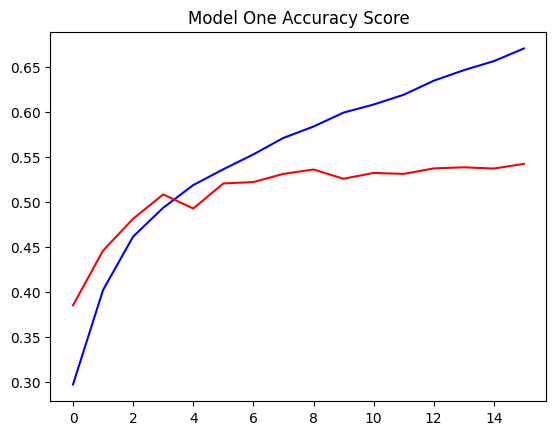

In [96]:
plt.plot(his1.history["accuracy"],"b",label="accuracy")
plt.plot(his1.history["val_accuracy"],"r",label="val_accuracy")
plt.title("Model One Accuracy Score")
plt.show()

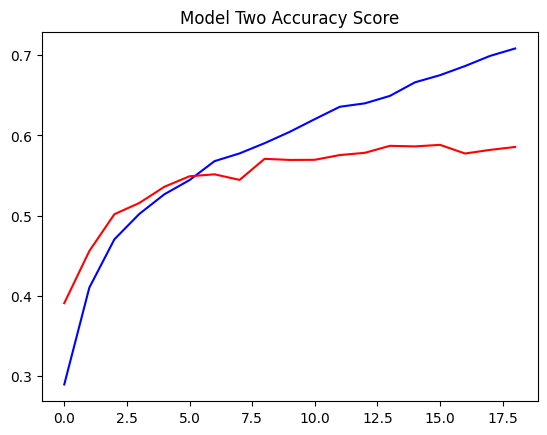

In [97]:
plt.plot(his2.history["accuracy"],"b",label="accuracy")
plt.plot(his2.history["val_accuracy"],"r",label="val_accuracy")
plt.title("Model Two Accuracy Score")
plt.show()

**The increase of the model complexity does not increased the model performance**

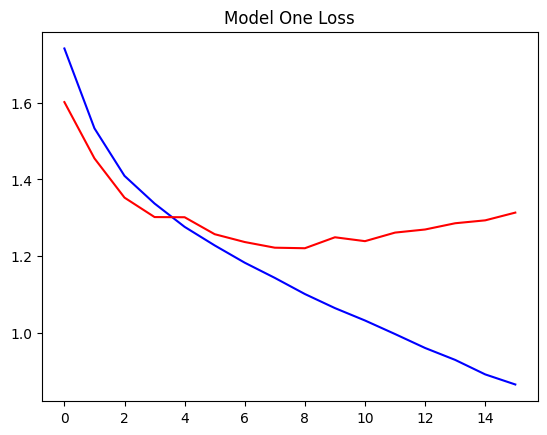

In [98]:
plt.plot(his1.history["loss"],"b",label="loss")
plt.plot(his1.history["val_loss"],"r",label="val_loss")
plt.title("Model One Loss")
plt.show()

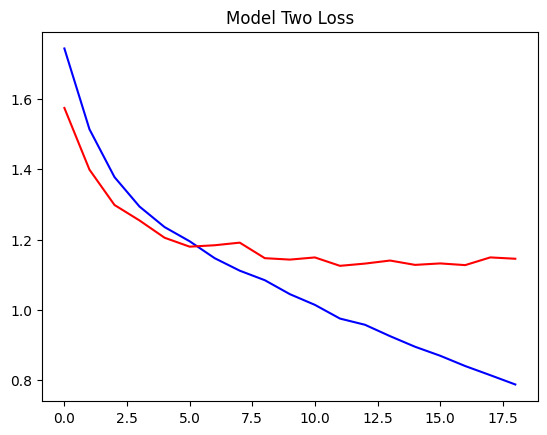

In [99]:
plt.plot(his2.history["loss"],"b",label="loss")
plt.plot(his2.history["val_loss"],"r",label="val_loss")
plt.title("Model Two Loss")
plt.show()

**The increase of the model complexity does not decreased the loss**

In [100]:
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test_one_hot)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5212 - loss: 1.2423


In [101]:
print("The loss for the first model is:", round(test_loss1, 1))

print("The accuracy score for the first model is:", round(test_accuracy1 * 100, 1), "%")

The loss for the first model is: 1.2
The accuracy score for the first model is: 55.0 %


In [102]:
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test_one_hot)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5498 - loss: 1.2137


W0000 00:00:1721513563.395854     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [104]:
print("The loss for the second model is:", round(test_loss2, 1))

print("The accuracy score for the second model is:", round(test_accuracy2 * 100, 1), "%")

The loss for the second model is: 1.1
The accuracy score for the second model is: 58.5 %


**Second model has better performance when we test it with almost 3%**

# Conclusion & Results


- We started understanding the problem, which is emotion detection classifier.
Then we inspected the images at a high level and discovered that we have 35,887 images.
- We applied multiple data preprocessing techniques to the images to make them readable by the Deep Learning model.
- We understood the data more, and the underlying distribution, and almost 25% of the images are of people who are happy.
- We have developed two Convolutional Neural Networks models.
- We fit our data to the model.
- We evaluated them and discovered that the two models have similar performance in the test set, with a 3% difference.
- I tried to create more complex models, but it did not increase the performance.
- I think if I used a pre-trained CNN model (e.g., ResNet) and fine-tuned it, it might give me better results with the given amount of data.


# Model Exporting & Notebook Containerization

In [105]:
model1.save('/kaggle/working/model1.h5')

In [106]:
model2.save('/kaggle/working/model2.h5')